### Block-push problem

$$
\min_{u(t), \mathbf{x}} \int_0^1 u^2(\tau) ~ d \tau, \qquad \text{subject to} \qquad
\begin{cases}
\dot{\mathbf{x}} &= f(t, \mathbf{x}, u) \\ 
\mathbf{x}(0) &= \begin{bmatrix} 0 & 0 \end{bmatrix}^T \\
\mathbf{x}(1) &= \begin{bmatrix} 1 & 0 \end{bmatrix}^T \\
\end{cases}
$$

where the dynamics are the double-integrator

$$
f(t, \mathbf{x}, u) = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \mathbf{x} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u
$$

In [1]:
import numpy as np

from archimedes.experimental import coco as cc

%load_ext autoreload
%autoreload 2

In [2]:
nx, nu = 2, 1
x0, xf = np.array([0.0, 0.0]), np.array([1.0, 0.0])
t0, tf = 0.0, 1.0


def j(t, x, u, p):
    return u**2


def f(t, x, u, p):
    return np.array([x[1], u[0]], like=x)


def cost(x0, t0, xf, tf, q, p):
    return q


# Discretize the domain
N = [10]
knots = []
domain = cc.RadauFiniteElements(N=N, knots=knots)

boundary_conditions = [
    cc.start_time(t0),
    cc.end_time(tf),
    cc.initial_condition(x0),
    cc.final_condition(xf),
]

# Define the optimal control problem
ocp = cc.OptimalControlProblem(
    nx=2,
    nu=1,
    ode=f,
    quad=j,
    cost=cost,
    boundary_constraints=boundary_conditions,
)


# Linearly interpolate initial guess
def x_guess(t):
    return x0 + (t - t0) * (xf - x0) / (tf - t0)


# Solve the optimal control problem
sol = ocp.solve(domain, t_guess=(t0, tf), x_guess=x_guess)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      286
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       34
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       26
Total number of inequality c

(1000,) (2,)
(1000,) (1000, 2) (1000, 2)
(1000, 2) (1000,) (1000,)
(1000,) (2,)
(1000,) (1000, 1) (1000, 1)
(1000, 1) (1000,) (1000,)


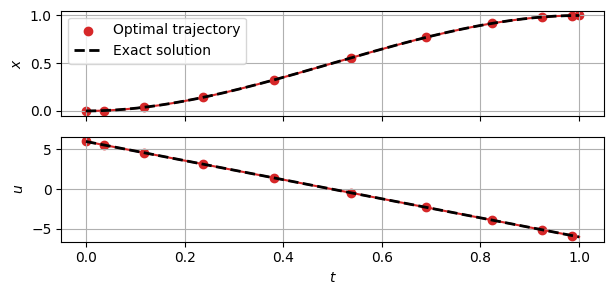

In [3]:
import matplotlib.pyplot as plt


def x_ex(t):
    return 3 * t**2 - 2 * t**3


def u_ex(t):
    return 6 - 12 * t


t0, tf = sol.t0, sol.tf
t_plt = np.linspace(t0, tf, 1000)
x_plt = sol.x(t_plt)
u_plt = sol.u(t_plt)

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].scatter(sol.tp, sol.xp[:, 0], c="tab:red", label="Optimal trajectory")
ax[0].plot(t_plt, x_plt[:, 0], c="tab:red")
ax[0].plot(t_plt, x_ex(t_plt), "k--", lw=2, label="Exact solution")
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel(r"$x$")
ax[1].scatter(sol.tp[:-1], sol.up, c="tab:red")
ax[1].plot(t_plt, u_plt, c="tab:red")
ax[1].plot(t_plt, u_ex(t_plt), "k--", lw=2)
ax[1].grid()
ax[1].set_ylabel(r"$u$")
ax[1].set_xlabel(r"$t$")

plt.show()

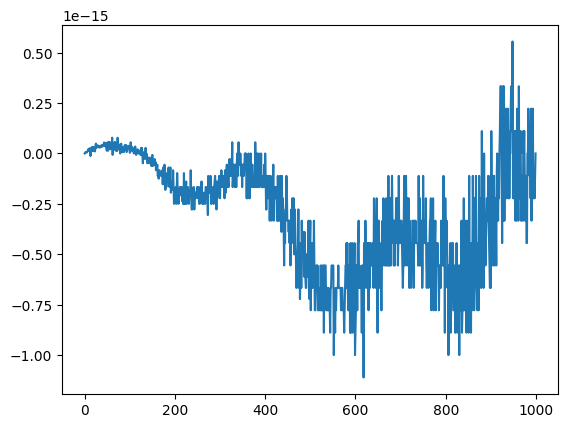

In [4]:
plt.plot(x_plt[:, 0] - x_ex(t_plt))

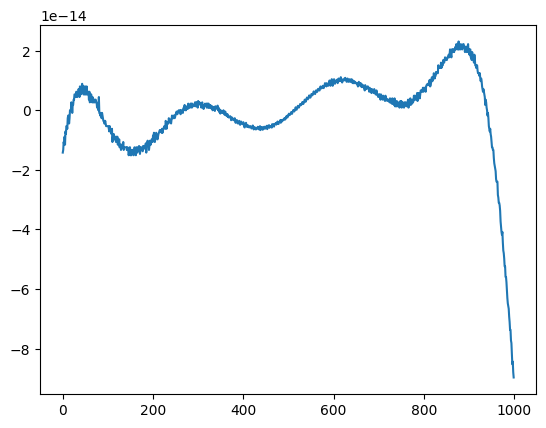

In [5]:
plt.plot(u_plt[:, 0] - u_ex(t_plt))

<bound method _AxesBase.set_yscale of <Axes: >>

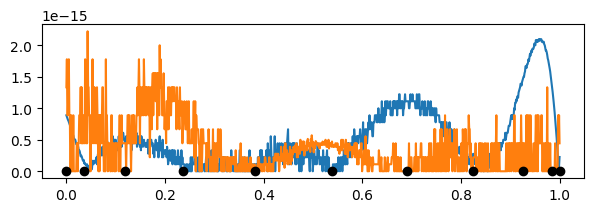

In [6]:
t0, tf = sol.t0, sol.tf
res_fn = ocp.dynamics_residual(sol, domain.elements[0], sol.xp, t0, tf)

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t_plt, res_fn(t_plt))
ax.plot(sol.tp, np.zeros_like(sol.tp), "ko")
ax.set_yscale